## Segment Continous EEG within MNE

1. We download and load the sample EEG data from MNE.

2. After segmenting the EEG data into `eeg_segments`, we create an `info` structure for the segmented data using `mne.create_info`. This structure provides the necessary information about the channels and sampling frequency.

3. We create an event array `events` to define events for each segment. Here, we assign a unique event code to each segment (1 for all segments), and we use a simple increasing counter as the event ID.

4. We create an `Epochs` object using `mne.EpochsArray`, which organizes the segmented EEG data into an MNE-friendly format. The `epochs` object can be used for further analysis with MNE-Python's tools and functions.

After these steps, we can use MNE-Python's extensive analysis and visualization capabilities on the segmented EEG data stored in the `epochs` object.

In [1]:
# if we want an interactive visualization, change backend to QT 
# make sure you have 'pip install pyqt5' and uncomment matplotlib.use('Qt5Agg)

import matplotlib
#matplotlib.use('Qt5Agg')

In [2]:
import mne
import numpy as np

# Load the sample EEG data (replace 'sample' with your dataset name if different)
data_path = mne.datasets.sample.data_path()
raw = mne.io.read_raw_fif(data_path + '/MEG/sample/sample_audvis_raw.fif', preload=True)
# Apply detrending
# Select only EEG channels
raw = raw.pick_types(eeg=True)

Opening raw data file C:\Users\babib\mne_data\MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


In [3]:
# Apply detrending
raw.filter(l_freq=None, h_freq=None, picks='eeg', 
           fir_design='firwin', phase='zero', verbose=False)
# raw.plot();

<Raw | sample_audvis_raw.fif, 59 x 166800 (277.7 s), ~78.0 MB, data loaded>

In [4]:
# Define parameters for the sliding window to segment the continuous EEG data

window_size_seconds = 4  # Size of the sliding window in seconds
overlap_seconds = 0.1      # Amount of overlap between consecutive windows in seconds

# Convert window parameters to samples
window_size_samples = int(window_size_seconds * raw.info['sfreq'])
overlap_samples     = int(overlap_seconds * raw.info['sfreq'])

# Initialize empty lists to store segmented EEG data and corresponding time information
eeg_segments = []
segment_start_times = []

In [5]:
# Loop through the EEG data with a sliding window

for start in range(0, len(raw) - window_size_samples, overlap_samples):
    start_time = raw.times[start]  # Start time of the current segment
    end_time   = raw.times[start + window_size_samples - 1]  # End time of the current segment
    # print('start_time =', start)
    # print('end_time =', start + window_size_samples - 1)
    # Extract the EEG data segment
    eeg_segment, _ = raw[:, start:start + window_size_samples]

    # Append the segment and its start time to the respective lists
    eeg_segments.append(eeg_segment)
    segment_start_times.append(start)

In [6]:
# Convert the lists to NumPy arrays for further analysis
eeg_segments = np.array(eeg_segments)
segment_start_times = np.array(segment_start_times)

# Create an info structure for the segmented data
segmented_info = mne.create_info(ch_names=raw.info['ch_names'], 
                                 sfreq=raw.info['sfreq'], ch_types='eeg')
print(segmented_info)

<Info | 7 non-empty values
 bads: []
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 59 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 300.3 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 600.6 Hz
>


In [7]:
# Create an event array for the segmented data (required for Epochs)
events = np.column_stack((segment_start_times, 
                          np.zeros(len(segment_start_times), dtype=int),
                          np.ones(len(segment_start_times), dtype=int)))

print(events[:10])

[[  0   0   1]
 [ 60   0   1]
 [120   0   1]
 [180   0   1]
 [240   0   1]
 [300   0   1]
 [360   0   1]
 [420   0   1]
 [480   0   1]
 [540   0   1]]


In [8]:
# Create an Epochs object
epochs = mne.EpochsArray(data=eeg_segments, info=segmented_info, events=events, tmin=0, event_id=None, verbose=True)

# Now, 'epochs' contains the segmented EEG data in MNE format, ready for further analysis.
# You can use MNE-Python's functions and methods to perform various analyses on these epochs.

Not setting metadata
Not setting metadata
2740 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [9]:
epochs.info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 59 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 300.3 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 600.6 Hz
>

Using matplotlib as 2D backend.


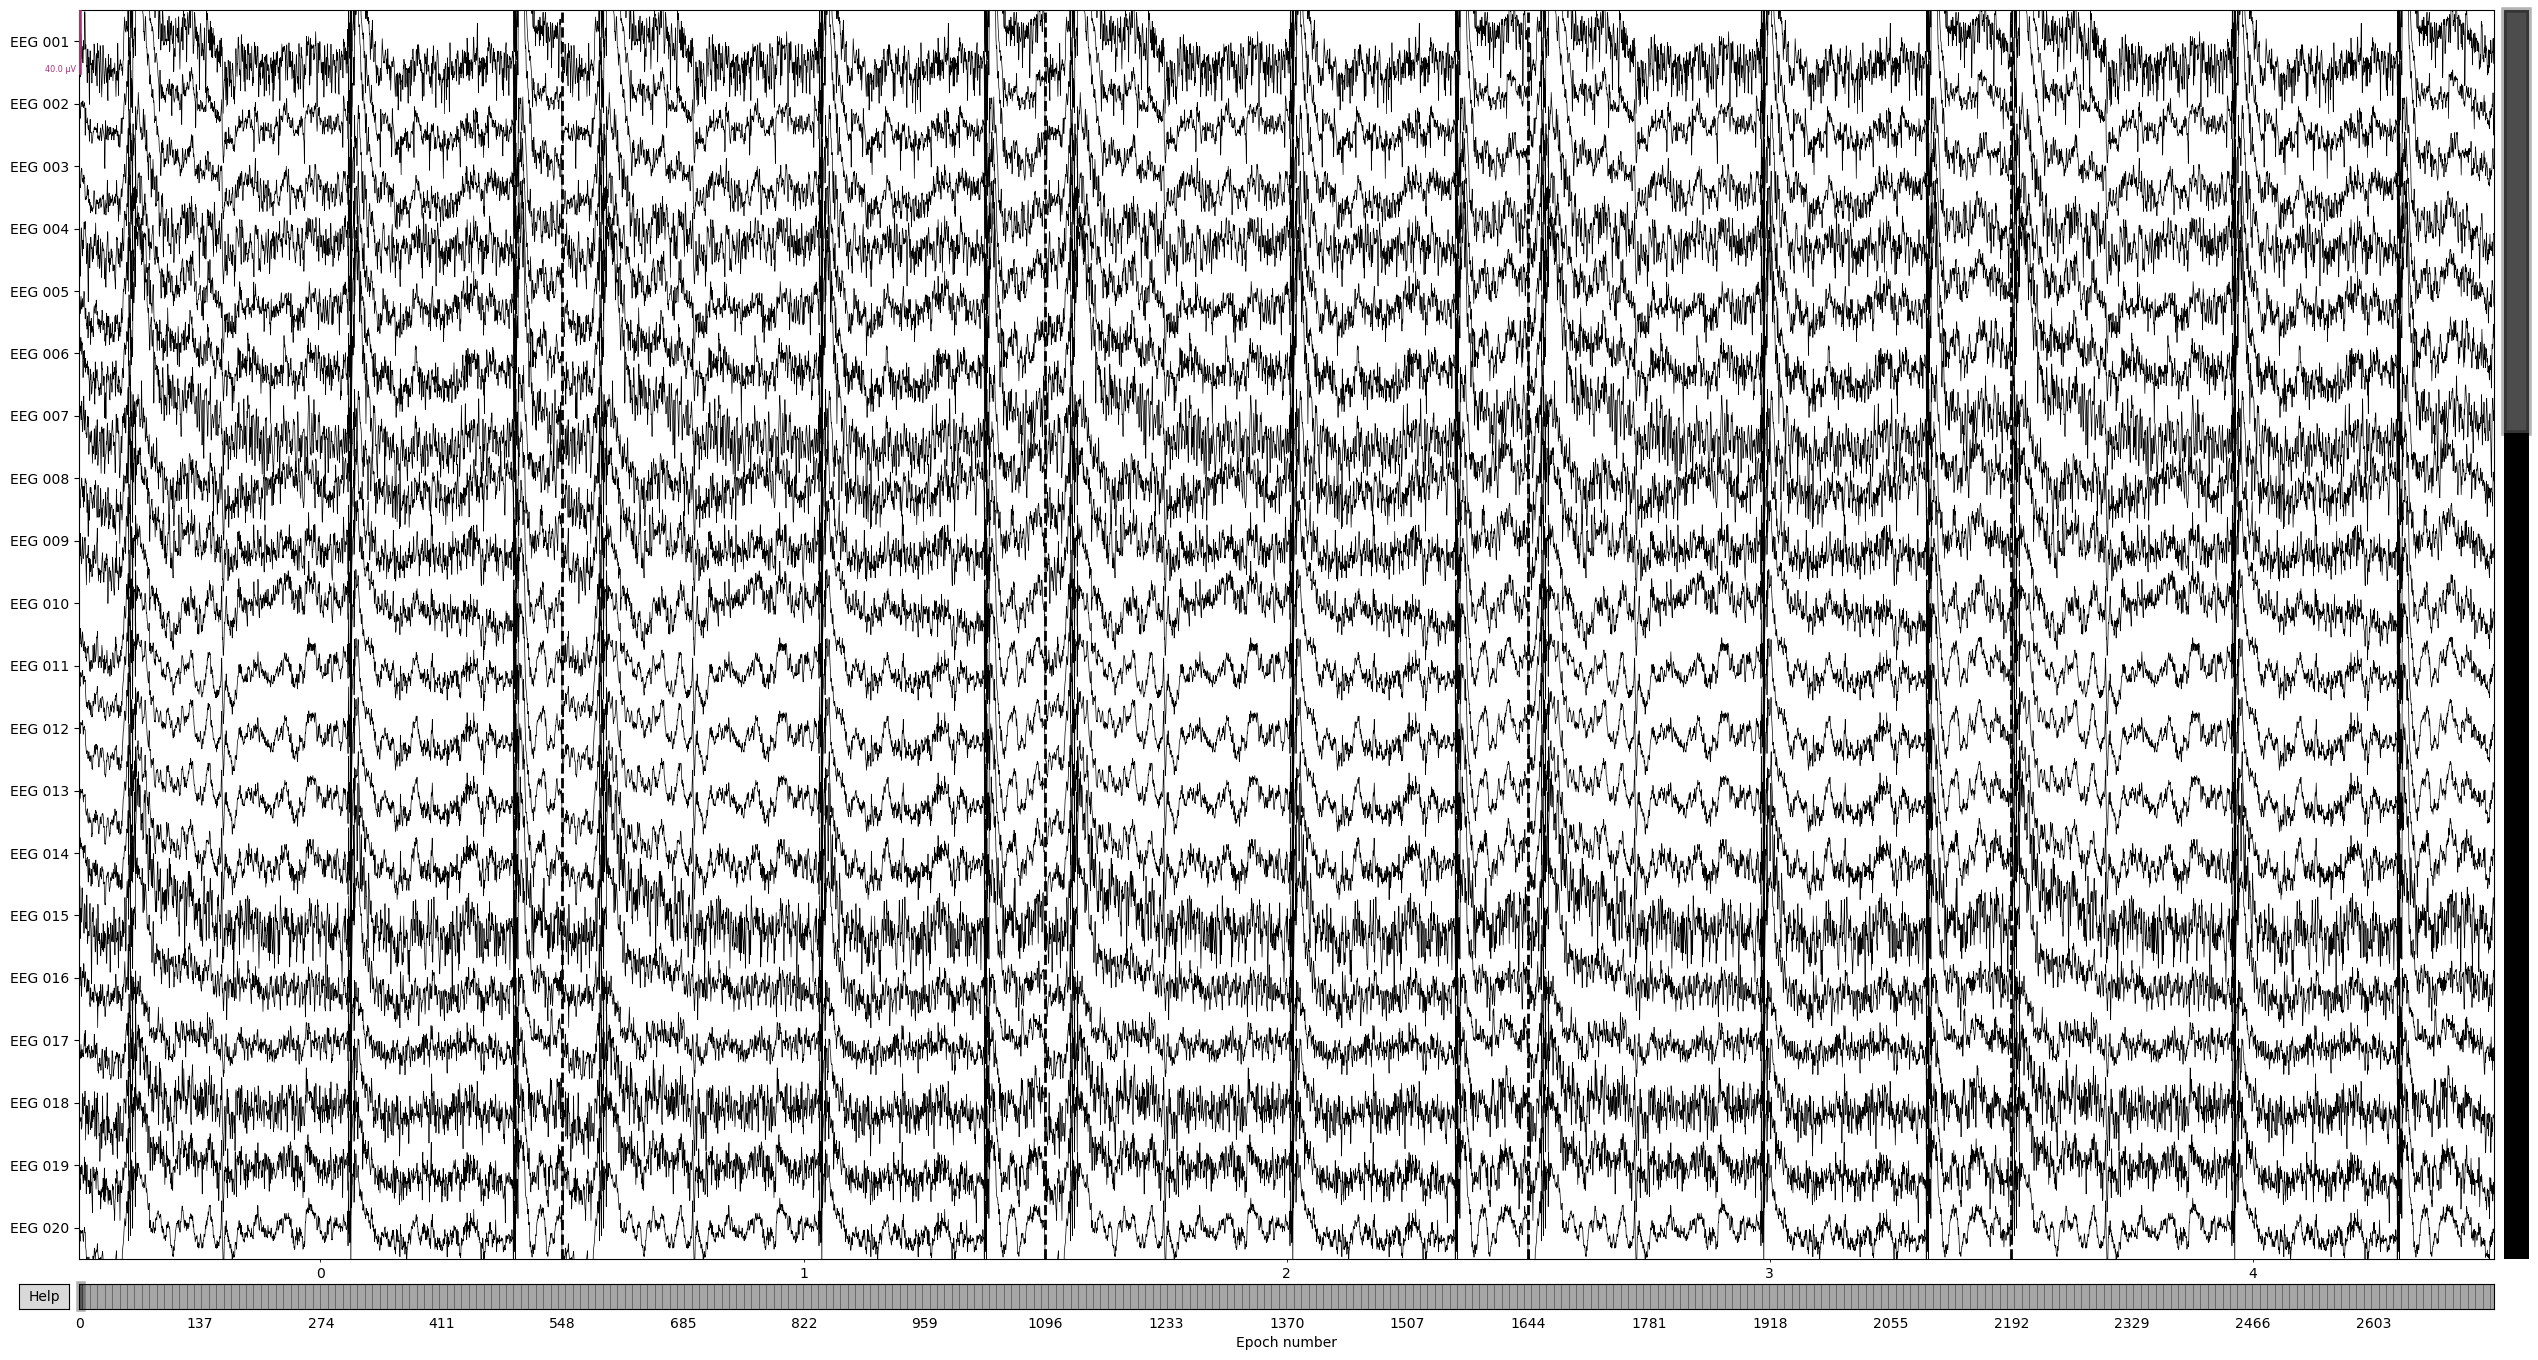

In [10]:
epochs.plot(n_epochs=5);

### Convert Continuous EEG in MATLAB format to MNE raw object

We use scipy.io.loadmat to load the MATLAB data file (eeg_data.mat in this example). Replace 'eeg_data.mat' with the path to your MATLAB data file.

We extract the EEG data and the sampling frequency from the loaded MATLAB data. Adjust the variable names ('eeg_data' and 'sampling_frequency') based on the structure of your MATLAB data.

We create an MNE info structure (info) that contains information about the EEG channels, including channel names, channel types (all EEG in this case), and the sampling frequency.

We create an MNE Raw object (raw) using the mne.io.RawArray constructor, passing in the EEG data and the info structure.

Now, the raw object contains your EEG data in the MNE-Python format, allowing you to perform various analyses and operations on it using MNE-Python.

In [ ]:
import scipy.io

# Load EEG data in MATLAB format (replace 'eeg_data.mat' with your file path)
matlab_data = scipy.io.loadmat('eeg_data.mat')

# Extract EEG data and sampling frequency from the MATLAB data
eeg_data = matlab_data['eeg_data']  # Replace 'eeg_data' with the variable name in your MATLAB file
sfreq = float(matlab_data['sampling_frequency'])  # Replace 'sampling_frequency' with the variable name in your MATLAB file

# Create an MNE info structure
ch_names = [f'EEG {i}' for i in range(eeg_data.shape[0])]  # EEG channel names
ch_types = ['eeg'] * eeg_data.shape[0]  # EEG channel types
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# Create an MNE Raw object
raw = mne.io.RawArray(eeg_data, info)

# Now, 'raw' contains your EEG data in MNE format, ready for further analysis, and the steps above can be used to segment the data 